### Import Libraries

In [1]:
# General Data Analysis and Numerical Operations
import os
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels

# Image Processing
import cv2  # OpenCV for advanced image preprocessing (optional)
from PIL import Image  # Pillow for basic image handling

# File Handling and Utilities
import os  # For directory and file path manipulation

# Sklearn for Scaling and Splitting Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # Optional for scaling pixel values


#  Generate a DataFrame for Image Files and Their Labels

In [2]:
from pathlib import Path

#dataset_dir = Path("path/to/dataset")
dataset_dir = Path("Resources/Rice_Image_Dataset")
classes = [d.name for d in dataset_dir.iterdir() if d.is_dir()]
#classes.remove('Rice_Citation_Request.txt')
num_classes = len(classes)

image_count = len(list(dataset_dir.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f"Number of classes: {num_classes}")
print("Classes:", classes)

Total images: 75000
Number of classes: 5
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


#  Generate a DataFrame for Image Files and Their Labels

In [3]:
# Define the base directory
base_dir = 'Resources/Rice_Image_Dataset'

# Initialize a list to hold image paths and labels
data = []

# Loop through each class folder in the base directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):  # Check if it's a directory
        for img_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, img_file)
            data.append([file_path, class_name])  # Append file path and class label

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Image', 'Label'])

# Display the first few rows
print(df.head())

                                               Image    Label
0  Resources/Rice_Image_Dataset\Arborio\Arborio (...  Arborio
1  Resources/Rice_Image_Dataset\Arborio\Arborio (...  Arborio
2  Resources/Rice_Image_Dataset\Arborio\Arborio (...  Arborio
3  Resources/Rice_Image_Dataset\Arborio\Arborio (...  Arborio
4  Resources/Rice_Image_Dataset\Arborio\Arborio (...  Arborio


#   Exploring Dataset Distribution by Class

In [4]:
# Define the dataset directory
dataset_dir = 'Resources/Rice_Image_Dataset'

# Initialize lists to store class names and their corresponding image counts
images_per_class = []
all_classes = []

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        total_images = len(os.listdir(class_dir))  # Count images in the folder
        images_per_class.append(total_images)  # Append image count
        all_classes.append(class_name)  # Append class name
        print(f'{class_name.capitalize()}: contains {total_images} images')



Arborio: contains 15000 images
Basmati: contains 15000 images
Ipsala: contains 15000 images
Jasmine: contains 15000 images
Karacadag: contains 15000 images


In [7]:
# Data generator with preprocessing
datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

# Load data
data_generator = datagen.flow_from_directory(
    'Resources/Rice_Image_Dataset',  # Path to the dataset
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,          # Number of images per batch
    class_mode='categorical'  # Multi-class classification
)

Found 75000 images belonging to 5 classes.


#   Distribution of Images in DataSet

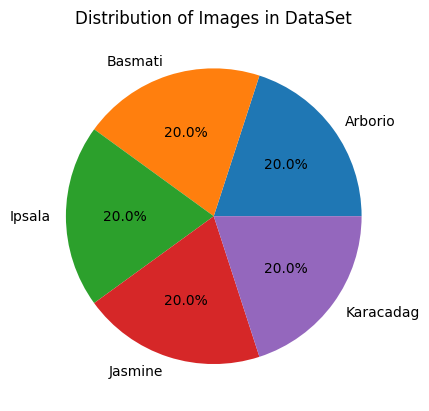

In [5]:
# Create pie chart
plt.pie(images_per_class, labels=all_classes, autopct='%1.1f%%')
plt.title('Distribution of Images in DataSet')
plt.show()

#  Distribution of Samples for Each Rice Class

C:\Users\manro\AppData\Local\Temp\ipykernel_21660\1825699558.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


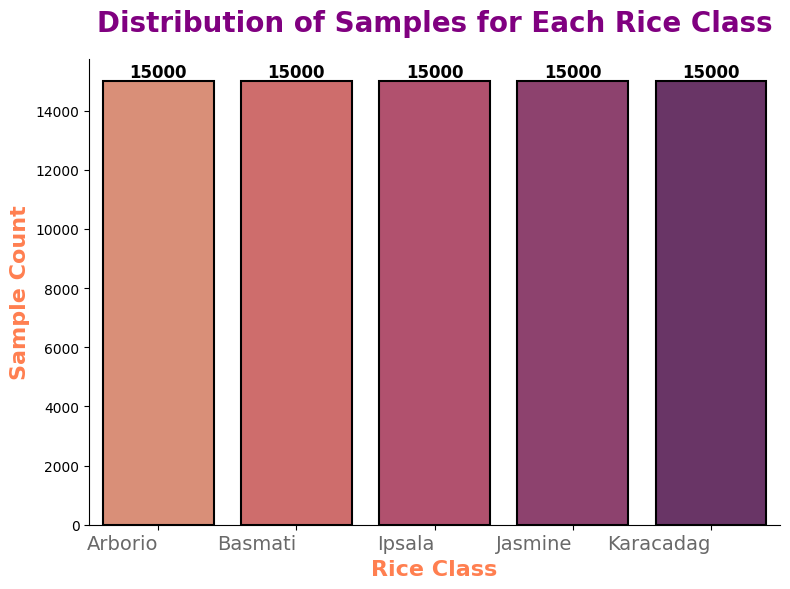

In [12]:
# Create a color palette
colors = sns.color_palette("flare", len(df[column_name].unique()))

# Plot the distribution of samples
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x=column_name,
    data=df,
    palette=colors,
    edgecolor="black",
    linewidth=1.5
)

# Add titles and labels
ax.set_title("Distribution of Samples for Each Rice Class", fontsize=20, weight='bold', color='purple', pad=20)
ax.set_xlabel("Rice Class", fontsize=16, weight='bold', color='coral')
ax.set_ylabel("Sample Count", fontsize=16, weight='bold', color='coral')
plt.xticks(ha='right', fontsize=14, color='dimgray')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', weight='bold')

# Final adjustments
sns.despine()
plt.tight_layout()
plt.show()


#  CNN Model

In [15]:
# Define the path to the dataset
base_dir = 'Resources/Rice_Image_Dataset'

# Image preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values
    validation_split=0.2      # Split dataset into training (80%) and validation (20%)
)

# Training data generator
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),   # Resize images to 128x128
    batch_size=32,            # Process 32 images at a time
    class_mode='categorical', # Multi-class classification
    subset='training'         # Training subset
)

Found 60000 images belonging to 5 classes.


In [16]:
# Validation data generator
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'       # Validation subset
)

Found 15000 images belonging to 5 classes.


In [17]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Convolutional layer
    MaxPooling2D((2, 2)),                                              # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),                             # Another convolutional layer
    MaxPooling2D((2, 2)),
    Flatten(),                                                         # Flatten output
    Dense(128, activation='relu'),                                     # Fully connected layer
    Dense(train_generator.num_classes, activation='softmax')           # Output layer (5 classes)
])

In [18]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1  # Adjust based on time availability
)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1137s 606ms/step - accuracy: 0.9366 - loss: 0.1917 - val_accuracy: 0.9791 - val_loss: 0.0598


In [20]:
# Save the model
model.save('rice_cnn_model.h5')
print("Model saved as rice_cnn_model.h5")

Model saved as rice_cnn_model.h5
